# Testing: Background
Created: 1/13/2022

Here we intend to test: 
- best background subtraction method for sending into estimator
- testing noise properties of files to select testing files

In [1]:
## imports
import os
import numpy as np
import pandas as pd
import numpy.ma as ma
import time
import scipy 
import importlib
import matplotlib
from astropy.stats import sigma_clipped_stats
from importlib import reload
from astropy.io import fits
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

import pipeline.code.Correlator as Cor

In [326]:
import warnings
warnings.filterwarnings('ignore')

In [304]:
### Selection1: by eye

dates = ["20180531", "20180601", "20181219", "20181221", "20181222", "20181223", "20210429", "20210430", "20210501", "20210502"]
files = ["0069", "0072", "0127", "0323", "0133", "0181", "0013", "0023", "0025", "0076"]

out_dir = "/home/emcewen/out/"

def fits_pull(date, file):
    file = f"{out_dir}{date}/fits/{date}_aocb{file}o_tmax200_stt.fits"
    if os.path.isfile(file):
        return file
    else:
        print(file, " not found")
        return ""


In [52]:
p_file = fits_pull(dates[1], files[1])

In [53]:
reload(Cor)
curr_data = Cor.Correlator("", "", "", f_file=p_file)

In [35]:
p_file

'/home/emcewen/out/20180601/fits/20180601_aocb0072o_tmax200_stt.fits'

## Testing background subtractions

Here we intend to compare four different methods of background subtractions. 
- rolling  subtraction
- flat 200 subtraction on avg
- flat 200 stack sigma subtraction on avg
- flat 200 stack sigma subtraction on median


(I tried the suggestion from this link but it was more than I needed https://stackoverflow.com/questions/65268285/why-is-numpy-slower-on-the-vectorized-for-loop-of-sigma-clipping )

In [55]:
# to work with raw data
data_x = curr_data.acor_x
data_y = curr_data.acor_y

In [36]:
mat = data_x[0]

#mat = np.transpose(mat, (1, 2, 0))

In [60]:
# simple gif two
def gif_two(data1, data2, f_len, title, out_file):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(6, 3))
    plt.setp(axes, xticks=[], yticks=[]) # turn off tick marks

    div1 = make_axes_locatable(axes[0])
    cax1 = div1.append_axes('right', '5%', '5%')
    div2 = make_axes_locatable(axes[-1])
    cax2 = div2.append_axes('right', '5%', '5%')

    im1 = axes[0].imshow(data1[0], origin='lower') # Here make an AxesImage rather than contour
    im2 = axes[1].imshow(data2[0], origin='lower')
    cb1 = fig.colorbar(im1, cax=cax1)
    cb2 = fig.colorbar(im2, cax=cax2)
    tx = fig.suptitle(f'{title} Step 0')
    fig.tight_layout()

    def animate(i):
        vstd1 = np.max(data1[i])
        im1.set_data(data1[i])
        #im1.set_clim(-vstd1, +vstd1)
        im2.set_data(data2[i])
        #im2.set_clim(-vstd2, +vstd2)
        tx.set_text(f'{title} Step {i}')

    ani = animation.FuncAnimation(fig, animate, frames=f_len)
    ani.save(out_file, writer = 'imagemagick')

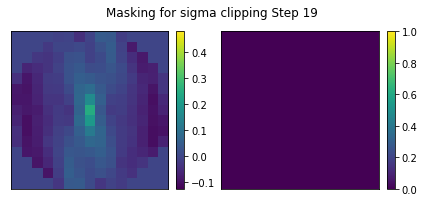

In [66]:
gif_two(mat, r_mask, 20, "Masking for sigma clipping", "sig_clip_test2.gif")

In [62]:
ac_x, ac_y = curr_data.data_get_ac(200,True,False,True,False)

In [63]:
man_x = cc.running_avg(data_x[0], 200)
man_y = cc.running_avg(data_y[0], 200)

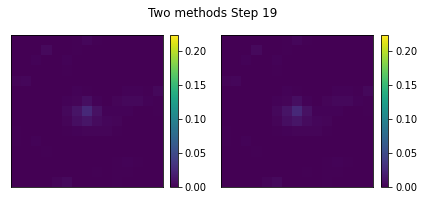

In [65]:
gif_two((data_x[0]-man_x+data_y[0]-man_y)/2, (ac_x[0] + ac_y[0])/2, 20, "Two methods", "out_check_sig.gif")

## Checking: Added background sub functionality

In [6]:
import pipeline.code.corr_code as cc
import pipeline.code.corr_plots as cp
from celluloid import Camera

In [7]:
def gen_column(data, subbed):
    return [subbed, data-subbed, data]

In [ ]:
# use this plotting code:
gif_3_rows_mat(mat_list_1, mat_list_2, mat_list_3, tmax, title = None, 
               out_file='out.gif', label_1=None, label_2=None, label_3=None)

In [8]:
def gif_3_rows_mat(mat_list, tmax, title = None, out_file='out.gif', label_y=None, label_x=None):
    mat_list_1, mat_list_2, mat_list_3 = mat_list
    min_val = np.amin(mat_list, axis= (1, 3, 4))
    max_val = np.amax(mat_list, axis= (1, 3, 4))
    n_len = 3
    n_width = len(mat_list_1)
    fig, axes = plt.subplots(nrows=n_len, ncols=n_width, figsize=(10,7), gridspec_kw={"width_ratios":[1 for n in range(n_width)]})
    fig.subplots_adjust(wspace=0.3)
    fig.suptitle(str(title))
    # setup
    for i in range(n_len):
            for j in range(n_width):
                ax = axes[i][j]
                ax.set_xlabel(label_y[i] + " , " + label_x[j])
                ax.set_xticklabels([])
                ax.set_yticklabels([])
                ax.tick_params(axis='y', which='both', right=False, left=False, labelleft=False)
    #animate
    camera = Camera(fig)
    for t in range(tmax):
        for i in range(n_len):
            for j in range(n_width):
                ax = axes[i][j]
                #im = ax.matshow(mat_list[i][j][t], vmin = min_val[i,t], vmax=max_val[i,t])
                im = ax.matshow(mat_list[i][j][t])
                ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
        ax.text(0.5,-0.5," t = " + str(t), transform=ax.transAxes)
        camera.snap()
    animation = camera.animate()  
    animation.save(out_file, writer = 'imagemagick') 

### Sigma clip on/off

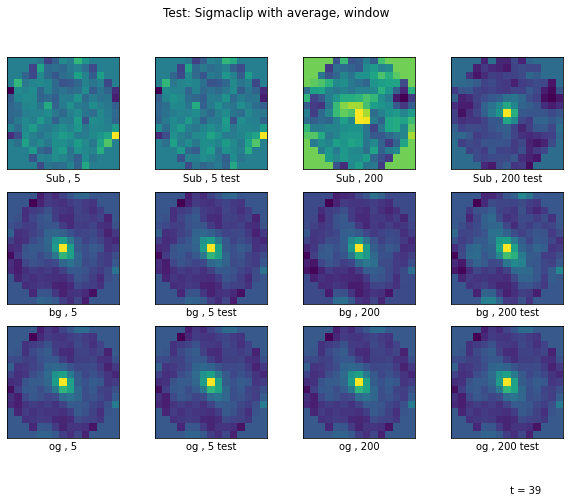

In [9]:
## Looking at avg, window, sigma clipping:
avg_len1 = 5
avg_len2 = 200

no_sub_x, no_sub_y = curr_data.data_get_ac(0,False,False,False,False)
no_sub = (no_sub_x[0]+no_sub_y[0])/2

## Get subbed data
len1_dx, len1_dy = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=False, mov_sub=True, sig_clip=False)
len1_tx, len1_ty = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=False, mov_sub=True, sig_clip=True) 

len2_dx, len2_dy = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=False, mov_sub=True, sig_clip=False)
len2_tx, len2_ty = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=False, mov_sub=True, sig_clip=True) 

bg_subed = [(len1_dx[0]+len1_dy[0])/2, (len1_tx[0]+len1_ty[0])/2, (len2_dx[0]+len2_dy[0])/2, (len2_tx[0]+len2_ty[0])/2]

### structure matrix arrays
bg_all = np.array([gen_column(no_sub, subbed) for subbed in bg_subed])
bg_all = np.transpose(bg_all, (1, 0, 2, 3, 4))

## plot
gif_3_rows_mat(bg_all, 40, title = "Test: Sigmaclip with average, window", out_file='out_sig_window.gif', label_y=["Sub", "bg", "og"], label_x=["5", "5 test", "200", "200 test"])

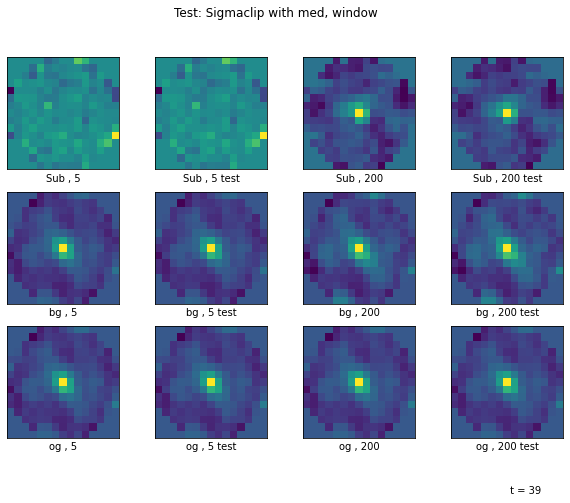

In [10]:
## Looking at avg, window, sigma clipping, med:
avg_len1 = 5
avg_len2 = 200

no_sub_x, no_sub_y = curr_data.data_get_ac(0,False,False,False,False)
no_sub = (no_sub_x[0]+no_sub_y[0])/2

## Get subbed data
len1_dx, len1_dy = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=True, mov_sub=True, sig_clip=False)
len1_tx, len1_ty = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=True, mov_sub=True, sig_clip=True) 

len2_dx, len2_dy = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=True, mov_sub=True, sig_clip=False)
len2_tx, len2_ty = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=True, mov_sub=True, sig_clip=True) 

bg_subed = [(len1_dx[0]+len1_dy[0])/2, (len1_tx[0]+len1_ty[0])/2, (len2_dx[0]+len2_dy[0])/2, (len2_tx[0]+len2_ty[0])/2]

### structure matrix arrays
bg_all = np.array([gen_column(no_sub, subbed) for subbed in bg_subed])
bg_all = np.transpose(bg_all, (1, 0, 2, 3, 4))

## plot
gif_3_rows_mat(bg_all, 40, title = "Test: Sigmaclip with med, window", out_file='out_sig_window_med.gif', label_y=["Sub", "bg", "og"], label_x=["5", "5 test", "200", "200 test"])

### windowing, on off, no clipping

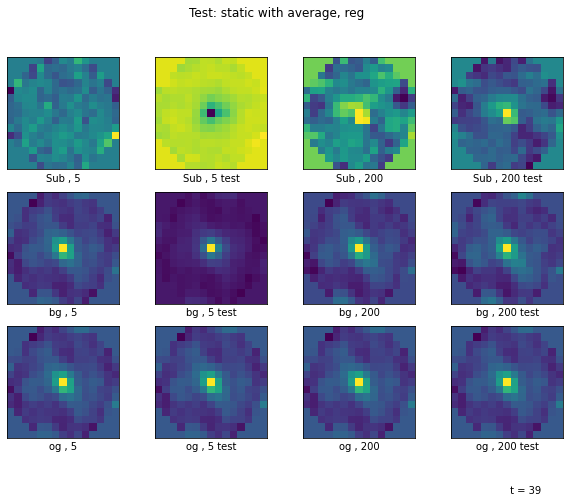

In [11]:
## looking at static, avg

avg_len1 = 5
avg_len2 = 200

no_sub_x, no_sub_y = curr_data.data_get_ac(0,False,False,False,False)
no_sub = (no_sub_x[0]+no_sub_y[0])/2

## Get subbed data
len1_dx, len1_dy = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=False, mov_sub=True, sig_clip=False)
len1_tx, len1_ty = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=False, mov_sub=False, sig_clip=False) 

len2_dx, len2_dy = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=False, mov_sub=True, sig_clip=False)
len2_tx, len2_ty = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=False, mov_sub=False, sig_clip=False) 

bg_subed = [(len1_dx[0]+len1_dy[0])/2, (len1_tx[0]+len1_ty[0])/2, (len2_dx[0]+len2_dy[0])/2, (len2_tx[0]+len2_ty[0])/2]

### structure matrix arrays
bg_all = np.array([gen_column(no_sub, subbed) for subbed in bg_subed])
bg_all = np.transpose(bg_all, (1, 0, 2, 3, 4))

## plot
gif_3_rows_mat(bg_all, 40, title = "Test: static with average, reg", out_file='out_reg_static.gif', label_y=["Sub", "bg", "og"], label_x=["5", "5 test", "200", "200 test"])

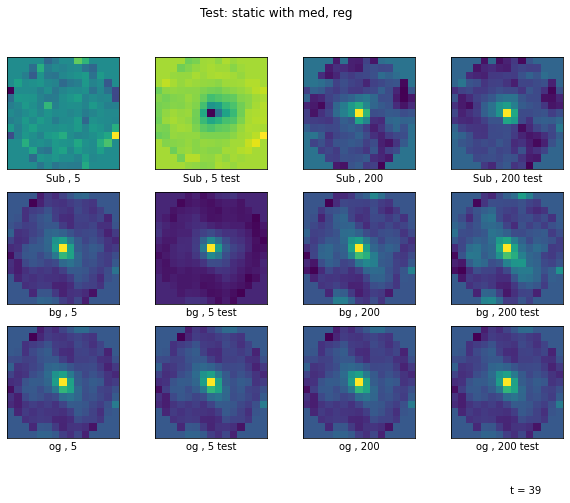

In [19]:
## Looking at static, med

avg_len1 = 5
avg_len2 = 200

no_sub_x, no_sub_y = curr_data.data_get_ac(0,False,False,False,False)
no_sub = (no_sub_x[0]+no_sub_y[0])/2

## Get subbed data
len1_dx, len1_dy = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=True, mov_sub=True, sig_clip=False)
len1_tx, len1_ty = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=True, mov_sub=False, sig_clip=False) 

len2_dx, len2_dy = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=True, mov_sub=True, sig_clip=False)
len2_tx, len2_ty = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=True, mov_sub=False, sig_clip=False) 

bg_subed = [(len1_dx[0]+len1_dy[0])/2, (len1_tx[0]+len1_ty[0])/2, (len2_dx[0]+len2_dy[0])/2, (len2_tx[0]+len2_ty[0])/2]

### structure matrix arrays
bg_all = np.array([gen_column(no_sub, subbed) for subbed in bg_subed])
bg_all = np.transpose(bg_all, (1, 0, 2, 3, 4))

## plot
gif_3_rows_mat(bg_all, 40, title = "Test: static with med, reg", out_file='out_reg_static_med.gif', label_y=["Sub", "bg", "og"], label_x=["5", "5 test", "200", "200 test"])


### windowing, on off, clipping

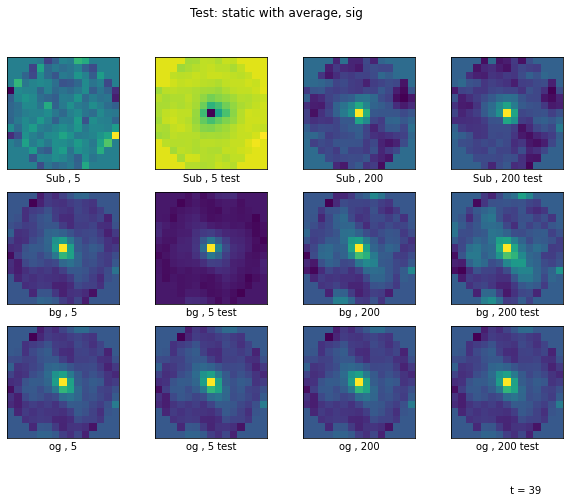

In [17]:
## Looking at static average, sigma clipped
avg_len1 = 5
avg_len2 = 200

no_sub_x, no_sub_y = curr_data.data_get_ac(0,False,False,False,False)
no_sub = (no_sub_x[0]+no_sub_y[0])/2

## Get subbed data
len1_dx, len1_dy = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=False, mov_sub=True, sig_clip=True)
len1_tx, len1_ty = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=False, mov_sub=False, sig_clip=True) 

len2_dx, len2_dy = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=False, mov_sub=True, sig_clip=True)
len2_tx, len2_ty = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=False, mov_sub=False, sig_clip=True) 

bg_subed = [(len1_dx[0]+len1_dy[0])/2, (len1_tx[0]+len1_ty[0])/2, (len2_dx[0]+len2_dy[0])/2, (len2_tx[0]+len2_ty[0])/2]

### structure matrix arrays
bg_all = np.array([gen_column(no_sub, subbed) for subbed in bg_subed])
bg_all = np.transpose(bg_all, (1, 0, 2, 3, 4))

## plot
gif_3_rows_mat(bg_all, 40, title = "Test: static with average, sig", out_file='out_sig_static.gif', label_y=["Sub", "bg", "og"], label_x=["5", "5 test", "200", "200 test"])

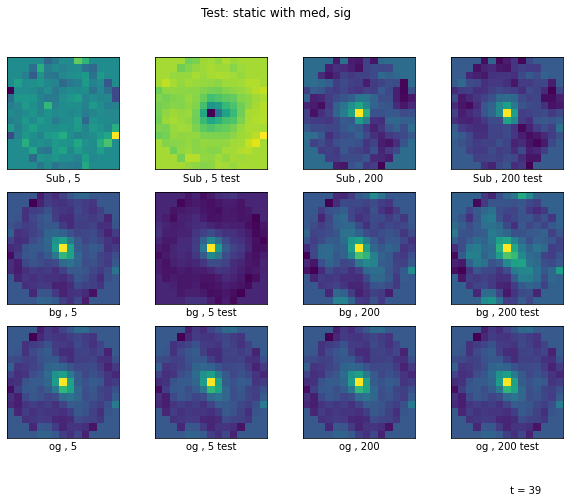

In [20]:
## Looking at static, med

avg_len1 = 5
avg_len2 = 200

no_sub_x, no_sub_y = curr_data.data_get_ac(0,False,False,False,False)
no_sub = (no_sub_x[0]+no_sub_y[0])/2

## Get subbed data
len1_dx, len1_dy = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=True, mov_sub=True, sig_clip=True)
len1_tx, len1_ty = curr_data.data_get_ac(avg_len1, bg_sub=True, med_sub=True, mov_sub=False, sig_clip=True) 

len2_dx, len2_dy = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=True, mov_sub=True, sig_clip=True)
len2_tx, len2_ty = curr_data.data_get_ac(avg_len2, bg_sub=True, med_sub=True, mov_sub=False, sig_clip=True) 

bg_subed = [(len1_dx[0]+len1_dy[0])/2, (len1_tx[0]+len1_ty[0])/2, (len2_dx[0]+len2_dy[0])/2, (len2_tx[0]+len2_ty[0])/2]

### structure matrix arrays
bg_all = np.array([gen_column(no_sub, subbed) for subbed in bg_subed])
bg_all = np.transpose(bg_all, (1, 0, 2, 3, 4))

## plot
gif_3_rows_mat(bg_all, 40, title = "Test: static with med, sig", out_file='out_sig_static_med.gif', label_y=["Sub", "bg", "og"], label_x=["5", "5 test", "200", "200 test"])


## Other testing

In [ ]:
## pull out the background more directly? understand why it's keeping central peak?

In [ ]:
# figure out what to graph (mean_sub or avg_sub)
data_x, data_y = self.data_get_ac(med_sub, avg_sub, avg_len)

# data_get_cc => this is what we have to edit to access different types of subtractions
# running_med

x_out = np.average(data_x, axis = 0)
y_out = np.average(data_y, axis = 0)

In [ ]:
## What are we currently doing to graph



data_cx, data_cy = self.data_get_cc_f_all(med_sub, avg_sub, avg_len)

gif_ccor_mat((data_cx+data_cy), dt_max, title, out_file)

In [ ]:
## four plot display of WFS0 with WFS0



In [ ]:
f = "/home/emcewen/out_test/20200122/fits/20200122_aocb0059o_tmax20_raw.fits"

In [ ]:
scipy.stats.sigmaclip(, low=4.0, high=4.0)

## Noise properties of files

The idea for quantifying this so far has been 

In [48]:
# working with estimator, want to be able to pill out sigma stats
avg_acor = curr_data.avg_acor(avg_sub = True, avg_len = 5, mov_sub=False, sig_clip=False)

In [30]:
rad_map = np.array([[np.sqrt(i**2 + j**2) for j in np.arange(-7, 8)] for i in np.arange(-7, 8)])
rad_map_boolean = np.zeros((8, 15, 15))
# boolean mask matrix
for i in np.arange(0, 8):
    rad_max = ma.masked_where(rad_map <=  i + 0.5, rad_map)
    rad_min = ma.masked_where(rad_map >  i - 0.5, rad_map)
    rad = rad_max.mask & rad_min.mask
    rad_map_boolean[i-1] = rad
rad_map_inv = np.ones(rad_map_boolean.shape) - rad_map_boolean

def stdv_map(avg_wf):
    #detect_lvl = np.zeros_like(avg_wfs)
    t_mean = np.zeros_like(avg_wf)
    t_stdev = np.zeros_like(avg_wf)
    
    list_stdev = []

    for t in range(avg_wf.shape[0]):
        # 1.1.  For each pixel in the cov map assign a radius
        t_slice = avg_wf[t]
        sigma = 3
        # 1.2. find the mean (m) and stddev (sd) of the pixels 
        # in a radial annuli one pixel wide (r from 1 to 7 +/- 0.5.  
        # I do a sigma clipping on this with a clip=3 si
        t_stdv = []
        for r in np.arange(8):
            rad_vals = np.multiply(t_slice, rad_map_boolean[r])
            mean, median, std = sigma_clipped_stats(rad_vals, sigma=sigma, mask=rad_map_inv[r])
            t_stdv.append(std)
        list_stdev.append(t_stdv)
    # 1.3. For each pixel I assign a "detection level in sigma over the mean"
    # = (im[x,y] - m)/sd.   
    # This results in a detection map for each cov map time slice. 
    #detect_map = np.divide(np.subtract(avg_wf, t_mean), t_stdev)
    return list_stdev

In [49]:
stdv_mp = stdv_map(avg_acor)

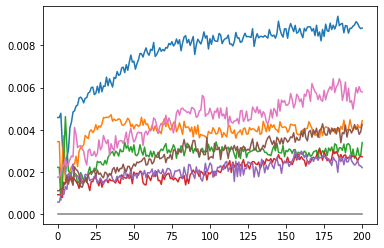

In [50]:
plt.plot(stdv_mp)
plt.show()

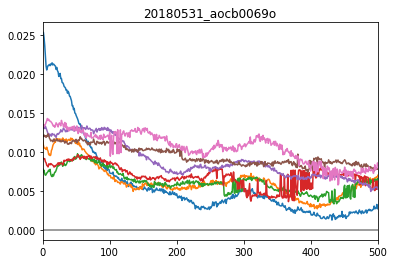

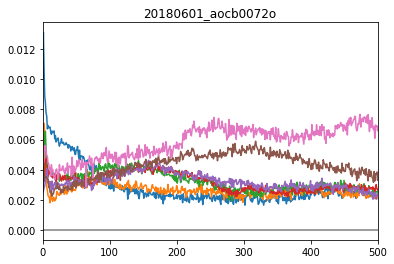

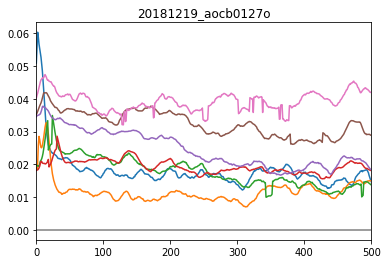

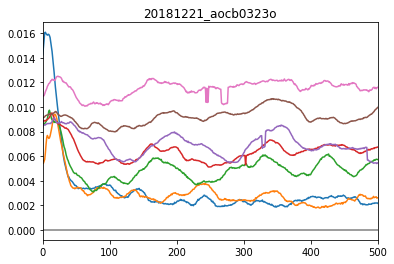

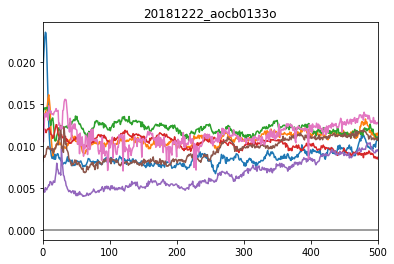

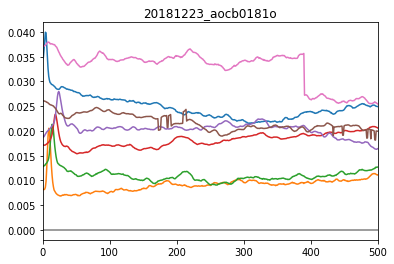

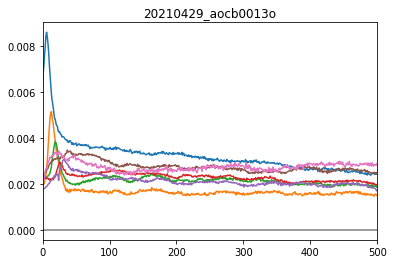

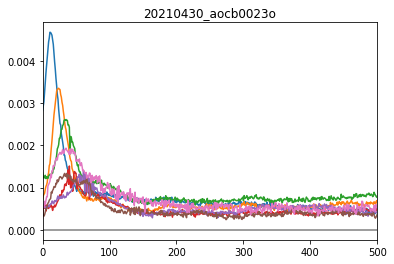

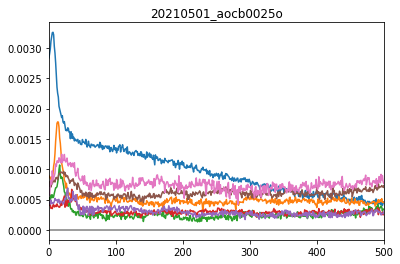

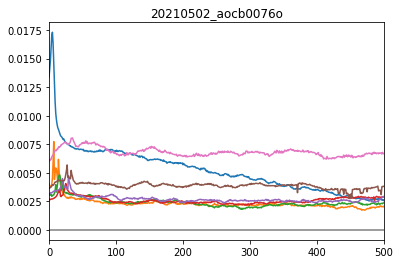

In [310]:
for i in range(len(dates)):
    p_file = fits_pull(dates[i], files[i])
    curr_data = Cor.Correlator("", "", "", f_file=p_file)
    avg_acor = curr_data.avg_acor(avg_sub = False, avg_len = 0, mov_sub=False, sig_clip=False)
    stdv_mp = stdv_map(avg_acor)
    
    plt.plot(stdv_mp)
    plt.xlim(0,500)
    plt.title(curr_data.name)
    plt.show()

### Maps for one night

for a whole night, pull all the stdv maps

In [70]:
import fnmatch
def fits_file_pull(DATE, suff='*stt.fits'):
    # pulling all fits given a date
    dir_pre = f"/home/emcewen/out/{DATE}/fits/"
    fits_in = []
    #check this directory is valid
    if os.path.isdir(dir_pre):
        files = os.listdir(dir_pre)   # list all files
        # collect fits with right suffix
        fits_in = [dir_pre + fn for fn in files if fnmatch.fnmatch(fn, suff)]
    fits_in.sort()
    return fits_in

In [ ]:
## for a whole night, pull all the stdv maps

In [71]:
files_1223 = fits_file_pull("20181223")

In [74]:
files_1223

144

In [75]:
# Iterate
sd_maps = []

for p_file in files_1223:
    curr_data = Cor.Correlator("", "", "", f_file=p_file)
    avg_acor = curr_data.avg_acor(avg_sub = False, avg_len = 0, mov_sub=False, sig_clip=False)
    stdv_mp = stdv_map(avg_acor)
    sd_maps.append(stdv_mp)

In [76]:
sd_maps_np = np.array(sd_maps)

In [77]:
# (files, time, radii)

sd_maps_np.shape

(144, 201, 8)

In [83]:
av_per_t = np.average(sd_maps_np, axis=(1))
sd_per_t = np.std(sd_maps_np, axis=(1))

In [84]:
sd_per_t.shape

(144, 8)

Text(0.5, 0, 'AOCB file number')

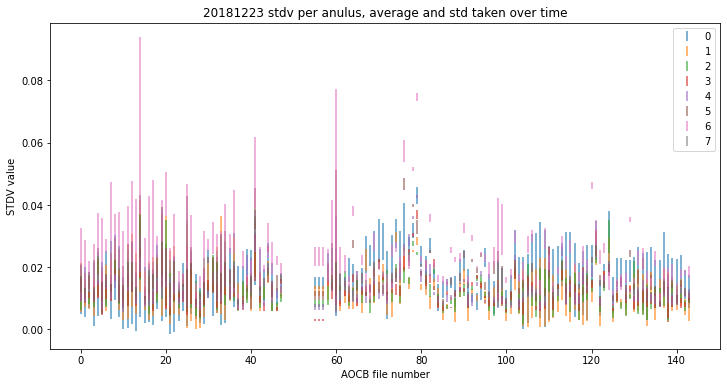

In [105]:
fig, ax = plt.subplots(figsize=(12, 6))
for rad in range(8):
    plt.errorbar(np.arange(144), av_per_t[:,rad], yerr=sd_per_t[:,rad], fmt="none", label=rad, alpha=0.75)

ax.legend()
plt.title(f"20181223 stdv per anulus, average and std taken over time")
plt.ylabel("STDV value")
plt.xlabel("AOCB file number")

Text(0.5, 0, 'AOCB file number')

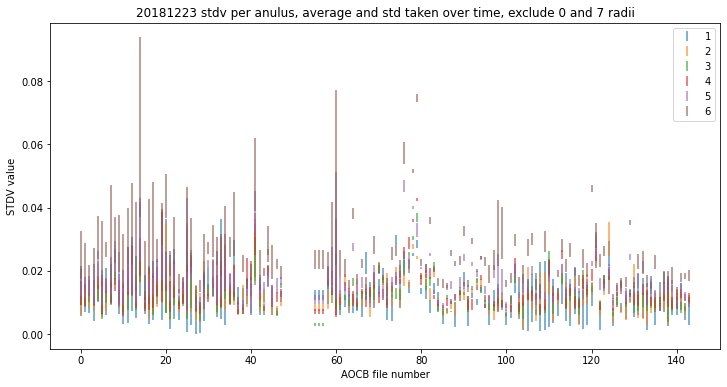

In [104]:
fig, ax = plt.subplots(figsize=(12, 6))
for rad in range(1,7):
    plt.errorbar(np.arange(144), av_per_t[:,rad], yerr=sd_per_t[:,rad], fmt="none",label=rad, alpha=0.75)

ax.legend()
plt.title(f"20181223 stdv per anulus, average and std taken over time, exclude 0 and 7 radii")
plt.ylabel("STDV value")
plt.xlabel("AOCB file number")

### take measurement for all nights

In [106]:
Dates = ["20180531", "20180601", "20181219", "20181221", "20181222", "20181223","20210429", "20210430", "20210501", "20210502"]

In [107]:
files_all = [fits_file_pull(d) for d in Dates]

In [115]:
new_array = np.array(files_all).flatten()

In [116]:
new_array.shape

(10,)

In [117]:
# big itterate
all_sd_maps = []

for date_f in files_all:
    sd_maps = []
    for p_file in date_f:
        curr_data = Cor.Correlator("", "", "", f_file=p_file)
        avg_acor = curr_data.avg_acor(avg_sub = False, avg_len = 0, mov_sub=False, sig_clip=False)
        stdv_mp = stdv_map(avg_acor)
        sd_maps.append(stdv_mp)
    all_sd_maps.append(sd_maps)

In [123]:
stats = []

for d_s in all_sd_maps:
    av_per_t = np.average(d_s, axis=(0,1,2))
    sd_per_t = np.std(d_s, axis=(0,1,2))
    stats.append([av_per_t, sd_per_t])

In [124]:
np.array(stats).shape

(10, 2)

In [132]:
stats = np.array(stats)

<ErrorbarContainer object of 3 artists>

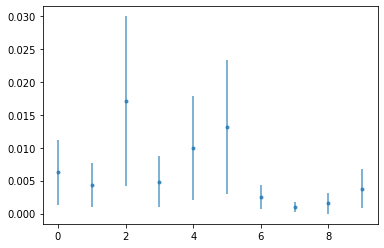

In [134]:
plt.errorbar(np.arange(10), stats[:,0], yerr=stats[:,1], fmt=".",label=rad, alpha=0.75)


In [216]:
# want: mean and variance of noise in each annulus
stats_ann = []

for d_s in all_sd_maps:
    d_s = np.array(d_s)
    av_per_t = np.average(d_s[:,100:,:], axis=(1))
    sd_per_t = np.std(d_s[:,100:,:], axis=(1))
    stats_ann.append([av_per_t, sd_per_t])

In [230]:
### Selection1: by eye

dates = ["20180531", "20180601", "20181219", "20181221", "20181222", "20181223", "20210429", "20210430", "20210501", "20210502"]
files = ["0069", "0072", "0127", "0323", "0133", "0181", "0013", "0023", "0025", "0076"]

out_dir = "/home/emcewen/out/"

Text(0.5, 1.0, '20180531 histogram, Ann. Noise, dt>100 ')

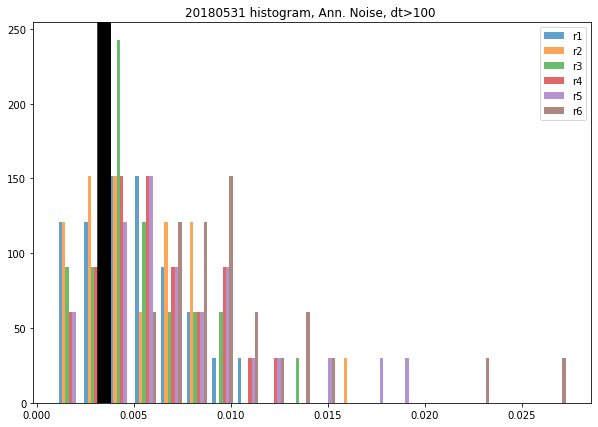

In [227]:
n_bins = 20
#x = np.random.randn(1000, 3)
x = np.array(stats_ann[0][0])[:,1:-1]

p_file = fits_pull(dates[0], files[0])
curr_data = Cor.Correlator("", "", "", f_file=p_file)
avg_acor = curr_data.avg_acor(avg_sub = False, avg_len = 0, mov_sub=False, sig_clip=False)
stdv_mp = np.array(stdv_map(avg_acor))

fig, ax0 = plt.subplots(nrows=1, ncols=1,figsize=(10, 7))


for y in np.std(stdv_mp[100:,:], axis=(1)):
    plt.axvline(y, color="black")

colors = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', "r7"]
ax0.hist(x, n_bins, density=True,  label=colors, alpha=0.7)
ax0.legend(prop={'size': 10})
ax0.set_title('20180531 histogram, Ann. Noise, dt>100 ')

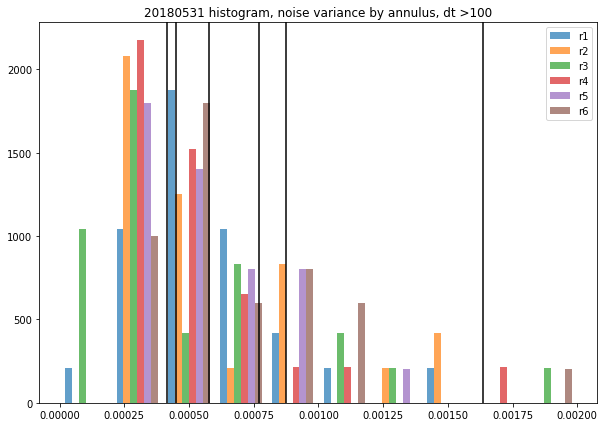

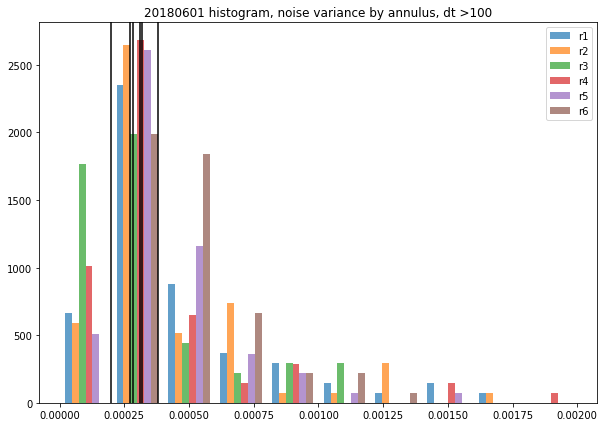

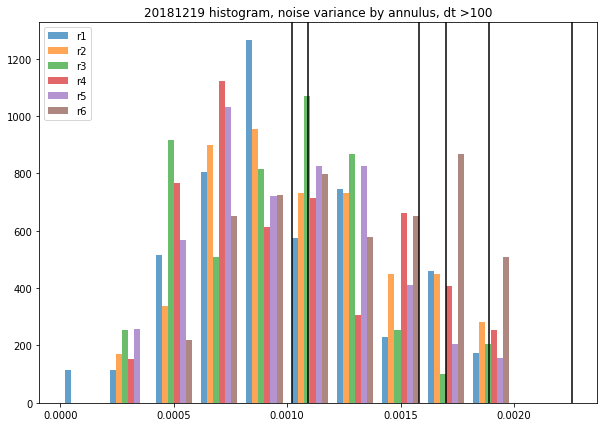

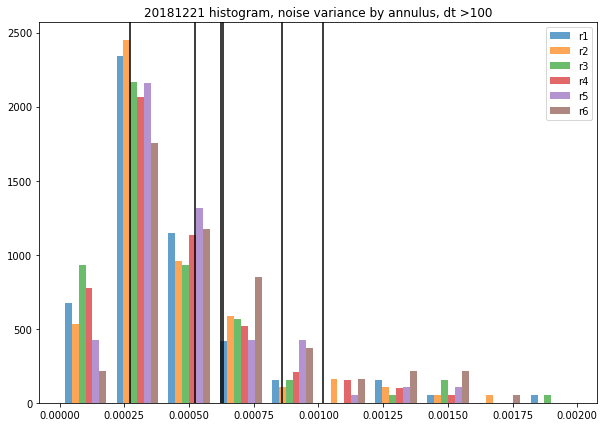

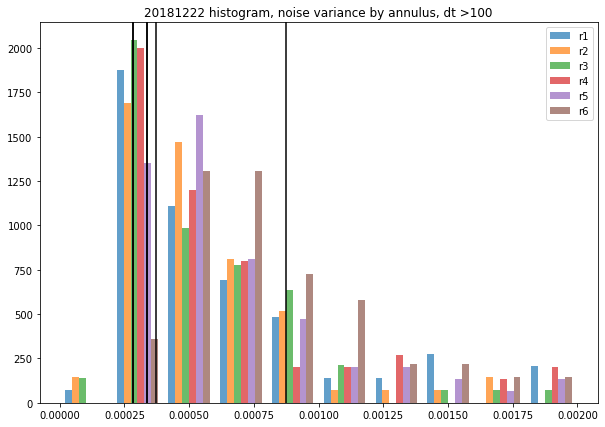

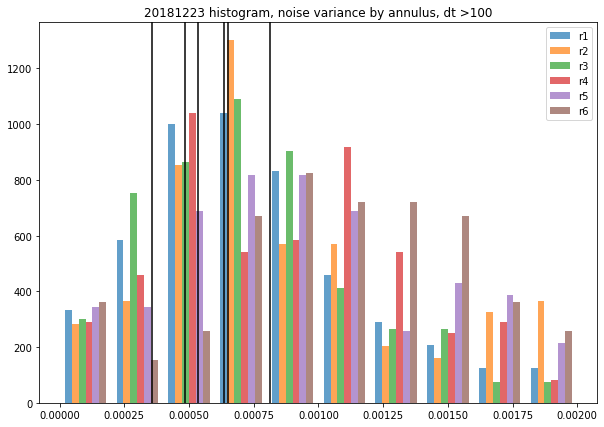

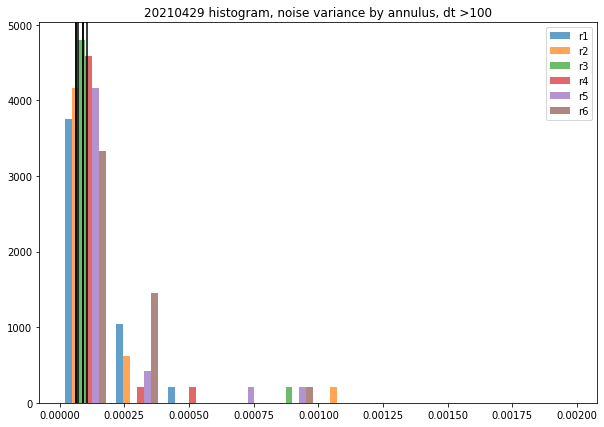

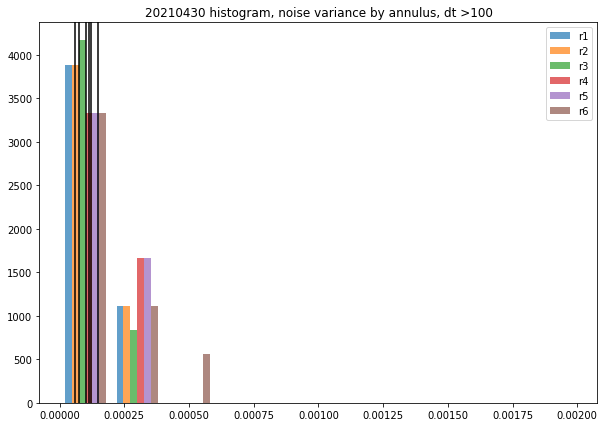

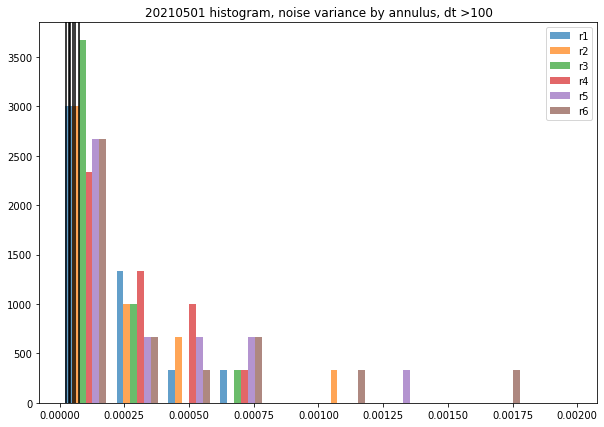

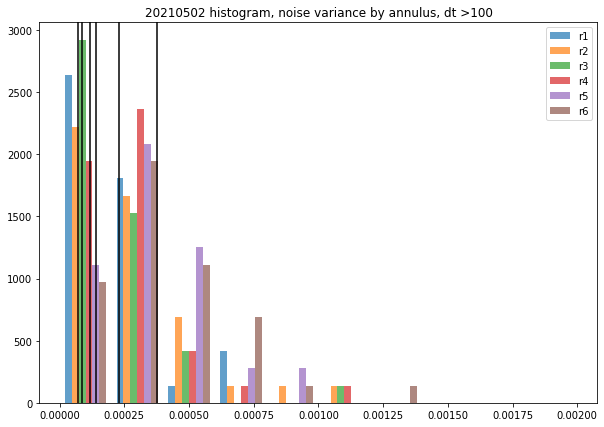

In [235]:
# Variance for all nights
for i in range(len(Dates)):
    date = Dates[i]
    n_bins = 20
    binwidth = 0.0002
    x = np.array(stats_ann[i][1])[:,1:-1]
    
    p_file = fits_pull(dates[i], files[i])
    curr_data = Cor.Correlator("", "", "", f_file=p_file)
    avg_acor = curr_data.avg_acor(avg_sub = False, avg_len = 0, mov_sub=False, sig_clip=False)
    stdv_mp = np.array(stdv_map(avg_acor))
    
    fig, ax0 = plt.subplots(nrows=1, ncols=1,figsize=(10, 7))
    colors = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', "r7"]
    ax0.hist(x, bins = np.arange(0.0, 0.002 + binwidth, binwidth), density=True,  label=colors, alpha=0.7)
    for y in np.std(stdv_mp[100:,1:-1], axis=(0)):
        ax0.axvline(y, color="black")
    ax0.legend(prop={'size': 10})
    ax0.set_title(date+' histogram, noise variance by annulus, dt >100')

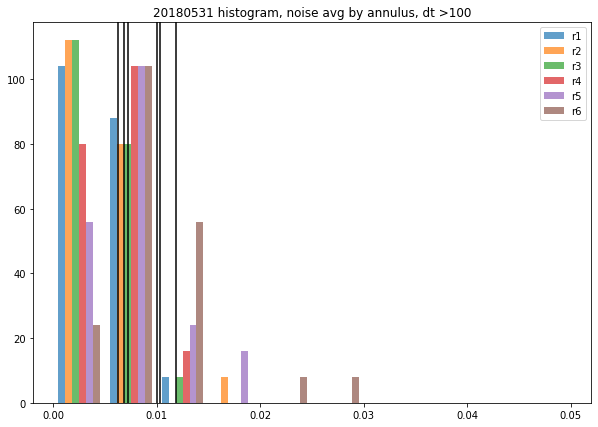

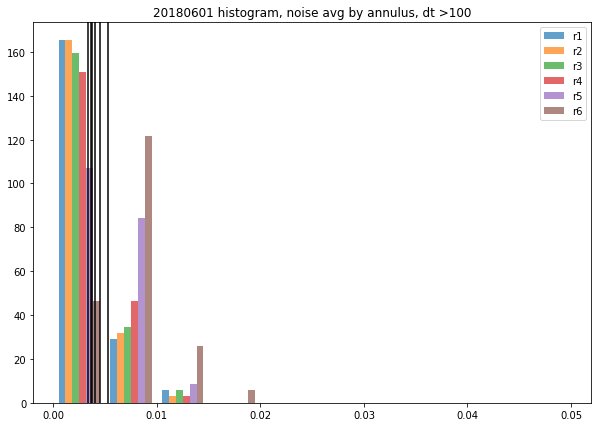

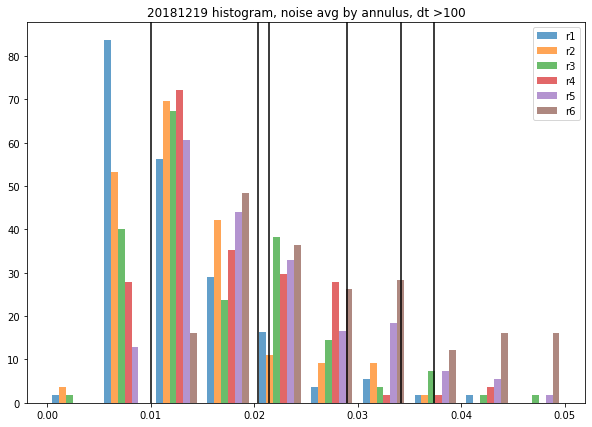

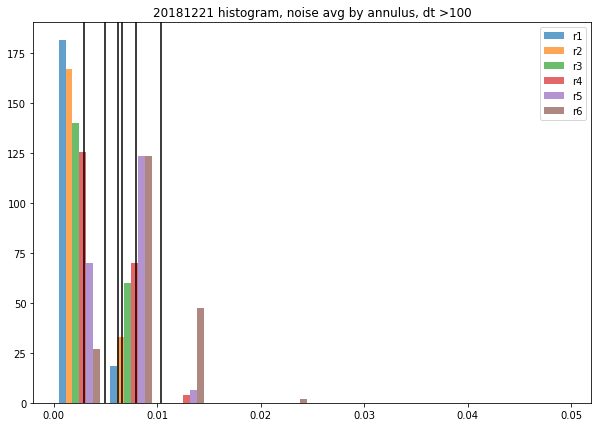

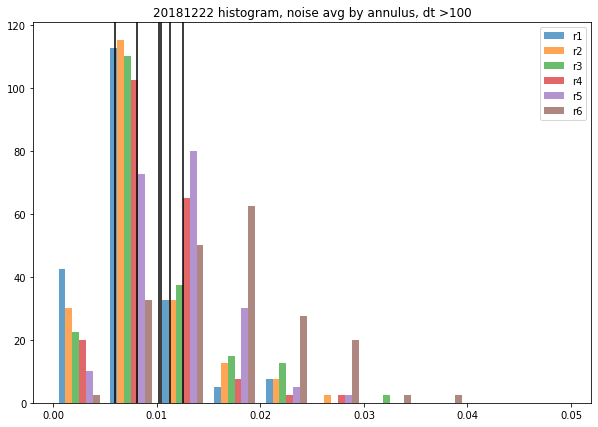

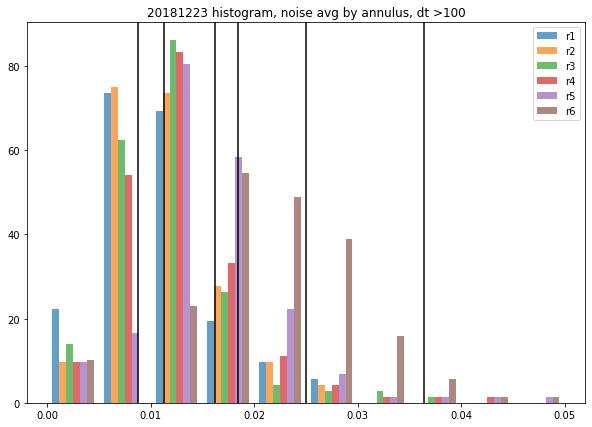

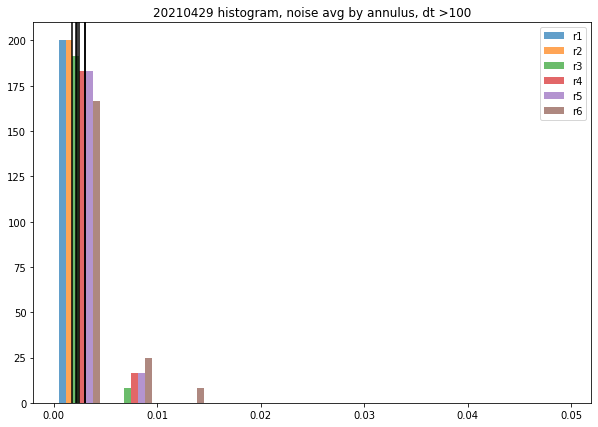

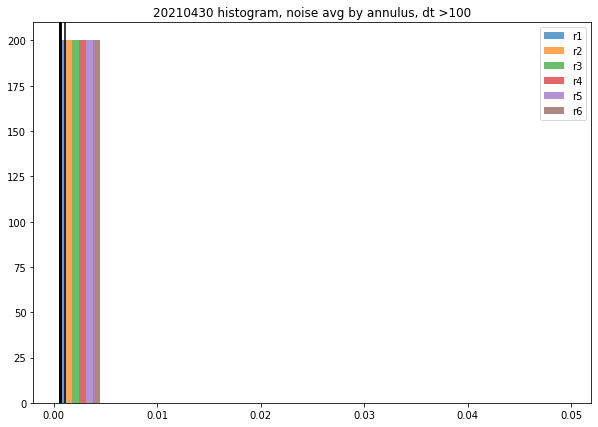

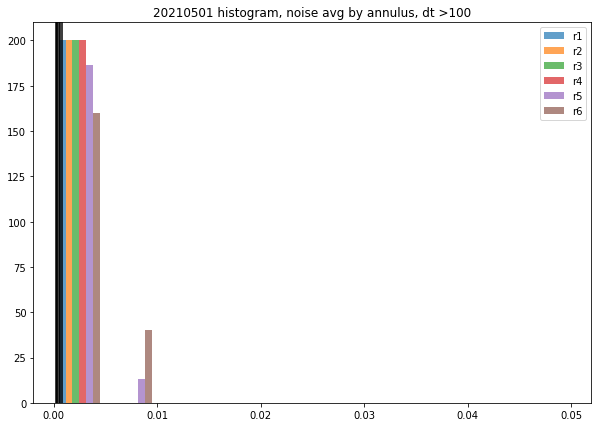

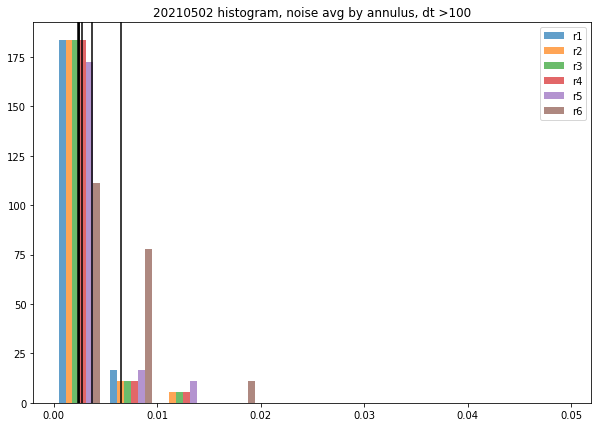

In [239]:
# Average noise for all nights
for i in range(len(Dates)):
    date = Dates[i]
    n_bins = 20
    binwidth = 0.005 
    x = np.array(stats_ann[i][0])[:,1:-1]
    
    p_file = fits_pull(dates[i], files[i])
    curr_data = Cor.Correlator("", "", "", f_file=p_file)
    avg_acor = curr_data.avg_acor(avg_sub = False, avg_len = 0, mov_sub=False, sig_clip=False)
    stdv_mp = np.array(stdv_map(avg_acor))

    fig, ax0 = plt.subplots(nrows=1, ncols=1,figsize=(10, 7))
    colors = ['r1', 'r2', 'r3', 'r4', 'r5', 'r6', "r7"]
    ax0.hist(x, bins = np.arange(0.0, 0.05 + binwidth, binwidth), density=True,  label=colors, alpha=0.7)
    for y in np.average(stdv_mp[100:,1:-1], axis=(0)):
        ax0.axvline(y, color="black")
    ax0.legend(prop={'size': 10})
    ax0.set_title(date+' histogram, noise avg by annulus, dt>100')

In [ ]:
def fits_aocb_pull(DATE, suff='*o.fits'):
    # pulling all fits given a date
    dir_pre = f"/data/imaka/{DATE}/ao/"
    fits_in = []
    #check this directory is valid
    if os.path.isdir(dir_pre):
        files = os.listdir(dir_pre)   # list all files
        # collect fits with right suffix
        fits_in = [dir_pre + fn for fn in files if fnmatch.fnmatch(fn, suff)]
    fits_in.sort()
    return fits_in

## pulling files

In [195]:
def aocb_pull(DATE, suff='*o.fits'):
    # pulling all fits given a date
    dir_pre = f"/data/imaka/{DATE}/ao/"
    fits_in = []
    #check this directory is valid
    if os.path.isdir(dir_pre):
        files = os.listdir(dir_pre)   # list all files
        # collect fits with right suffix
        fits_in = [fn.replace(".fits", "") for fn in files if fnmatch.fnmatch(fn, suff)]
    fits_in.sort()
    return fits_in

In [211]:
[print(p) for p in aocb_pull("20220125")]

aocb0003o
aocb0007o
aocb0012o
aocb0016o
aocb0020o
aocb0024o
aocb0028o
aocb0032o
aocb0036o


[None, None, None, None, None, None, None, None, None]

# Testing BG for estimator, radial

In [327]:
# Radial Estimator
import pipeline.code.Estimator_R as er

In [333]:
reload(er)

<module 'pipeline.code.Estimator_R' from '/home/emcewen/code_dev/pipeline/code/Estimator_R.py'>

In [334]:
### Selection1: by eye

dates = ["20180531", "20180601", "20181219", "20181221", "20181222", "20181223", "20210429", "20210430", "20210501", "20210502"]
files = ["0069", "0072", "0127", "0323", "0133", "0181", "0013", "0023", "0025", "0076"]

out_dir = "/home/emcewen/out/"

def fits_pull(date, file):
    file = f"{out_dir}{date}/fits/{date}_aocb{file}o_tmax1000_tts.fits"
    if os.path.isfile(file):
        return file
    else:
        print(file, " not found")
        return ""

In [335]:
long_files =  [fits_pull(dates[i], files[i]) for i in range(len(dates))]

file: /home/emcewen/out/20180531/fits/20180531_aocb0069o_tmax1000_tts.fits
== finished in 128.08491945266724 s
file: /home/emcewen/out/20180601/fits/20180601_aocb0072o_tmax1000_tts.fits
== finished in 118.62546133995056 s
file: /home/emcewen/out/20181219/fits/20181219_aocb0127o_tmax1000_tts.fits
== finished in 128.0938594341278 s
file: /home/emcewen/out/20181221/fits/20181221_aocb0323o_tmax1000_tts.fits
== finished in 122.04967427253723 s
file: /home/emcewen/out/20181222/fits/20181222_aocb0133o_tmax1000_tts.fits
== finished in 129.26500511169434 s
file: /home/emcewen/out/20181223/fits/20181223_aocb0181o_tmax1000_tts.fits
== finished in 120.2690966129303 s
file: /home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax1000_tts.fits
== finished in 128.33501625061035 s
file: /home/emcewen/out/20210430/fits/20210430_aocb0023o_tmax1000_tts.fits
== finished in 122.65868473052979 s
file: /home/emcewen/out/20210501/fits/20210501_aocb0025o_tmax1000_tts.fits
== finished in 122.21715974807739 s
fil

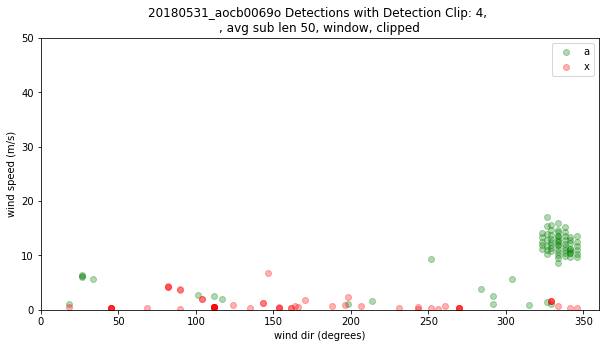

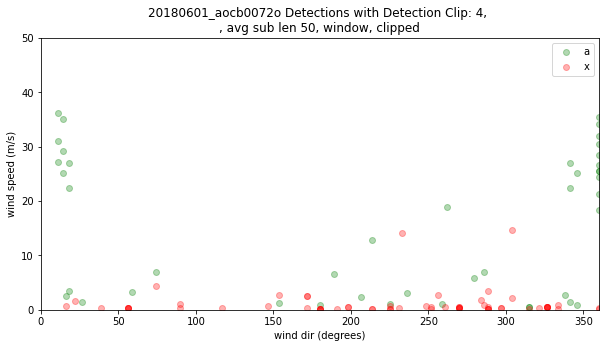

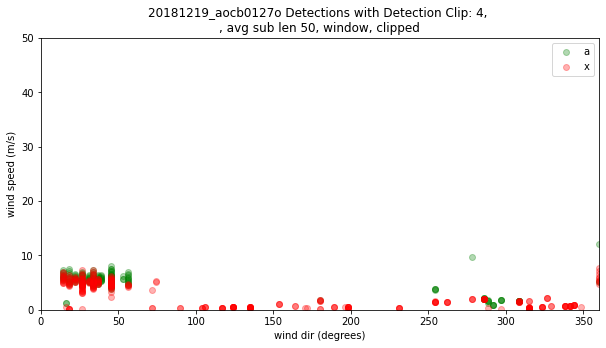

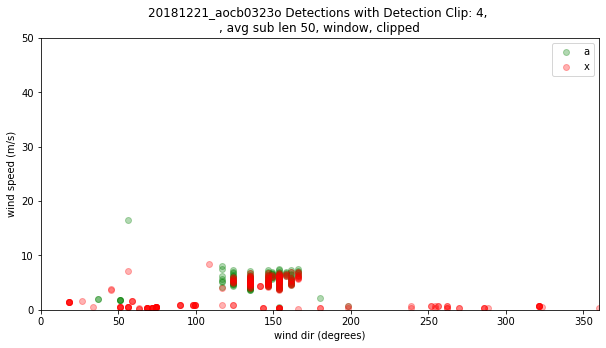

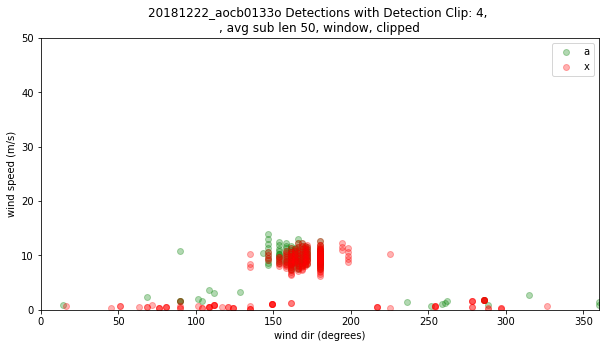

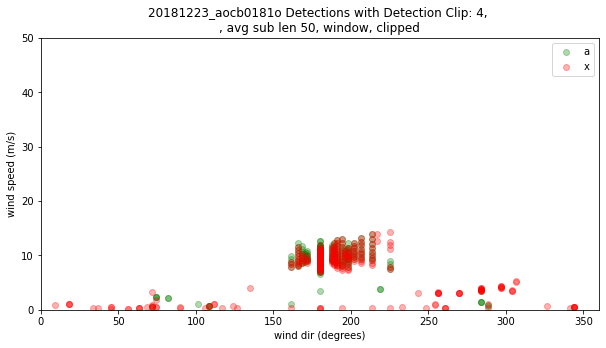

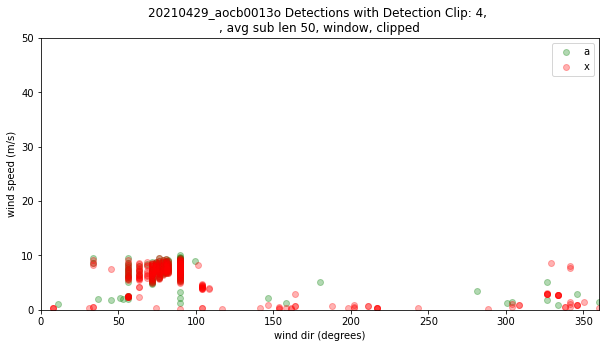

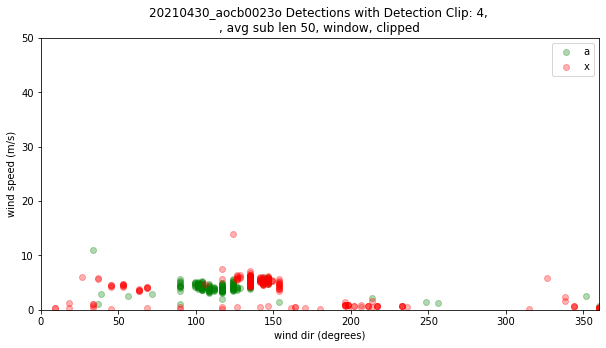

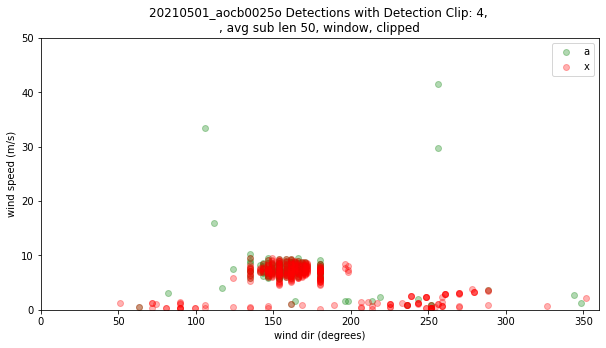

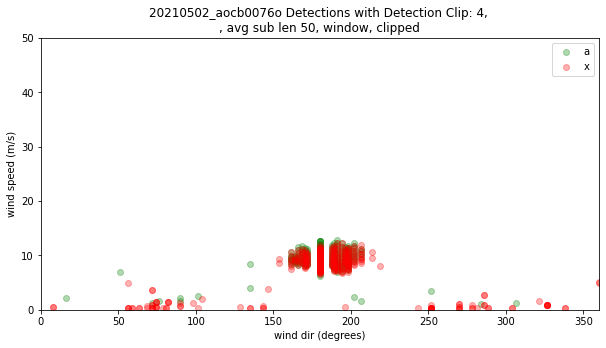

In [338]:
df_test = pd.DataFrame()

for i in range(len(dates)):

    t0 = time.time()
    cor_file = long_files[i]
    print(f"file: {cor_file}")

    er_pipe = er.Estimate_simple(cor_file)
    er_pipe.update_wfs([True, True, True, False, False])
    er_pipe.update_data_params(est_len = 250, bg_sub = True, move_sub = True, sub_len = 50)
    er_pipe.detect_clp = 4

    table_tmp = er_pipe.return_table(sdv_cnd = 2, n_filter = 10)
    n = table_tmp.shape[0]
    #table_tmp = table_tmp.assign(date=[dates[i]]*n, r0=[r0s[j]]*n, vspd=[vspds[k]]*n, vdir=[vdirs[m]]*n)
    table_tmp = table_tmp.assign(est_len=[er_pipe.est_len]*n, bg_sub=[er_pipe.bg_sub]*n, sub_len=[er_pipe.sub_len]*n)

    #add this table to a list of tables                             
    df_test = pd.concat([df_test, table_tmp])
    er_pipe.plot_spds_detect().show()
    t1 = time.time()
    print("== finished in %s s"% str(t1-t0))

In [340]:
df_w100 = df_test

file: /home/emcewen/out/20180531/fits/20180531_aocb0069o_tmax1000_tts.fits
== finished in 86.14199709892273 s
file: /home/emcewen/out/20180601/fits/20180601_aocb0072o_tmax1000_tts.fits
== finished in 86.09112167358398 s
file: /home/emcewen/out/20181219/fits/20181219_aocb0127o_tmax1000_tts.fits
== finished in 93.59903454780579 s
file: /home/emcewen/out/20181221/fits/20181221_aocb0323o_tmax1000_tts.fits
== finished in 90.21606826782227 s
file: /home/emcewen/out/20181222/fits/20181222_aocb0133o_tmax1000_tts.fits
== finished in 102.23933911323547 s
file: /home/emcewen/out/20181223/fits/20181223_aocb0181o_tmax1000_tts.fits
== finished in 95.58573865890503 s
file: /home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax1000_tts.fits
== finished in 88.66062831878662 s
file: /home/emcewen/out/20210430/fits/20210430_aocb0023o_tmax1000_tts.fits
== finished in 88.63513684272766 s
file: /home/emcewen/out/20210501/fits/20210501_aocb0025o_tmax1000_tts.fits
== finished in 88.7030668258667 s
file: /hom

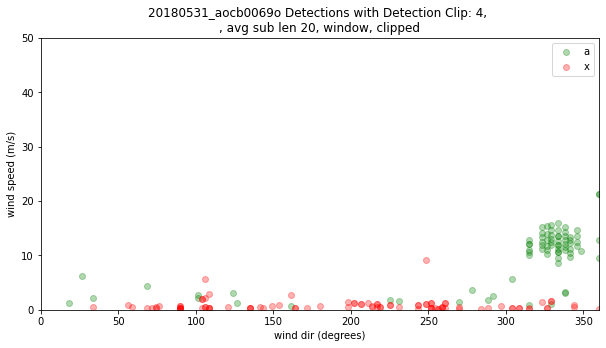

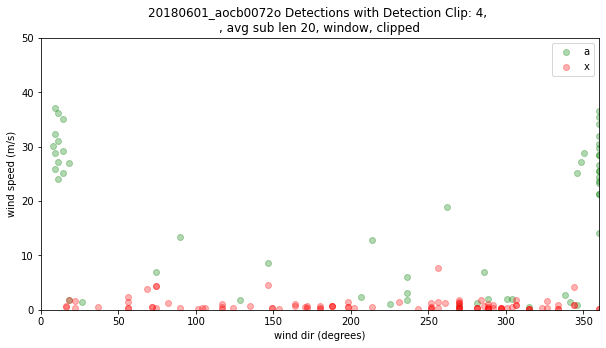

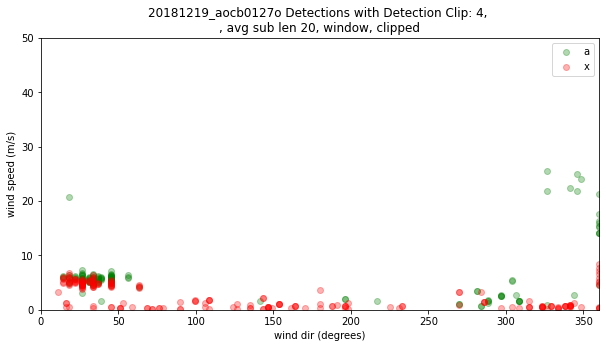

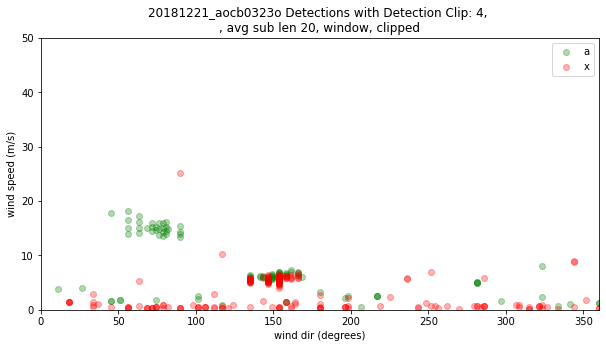

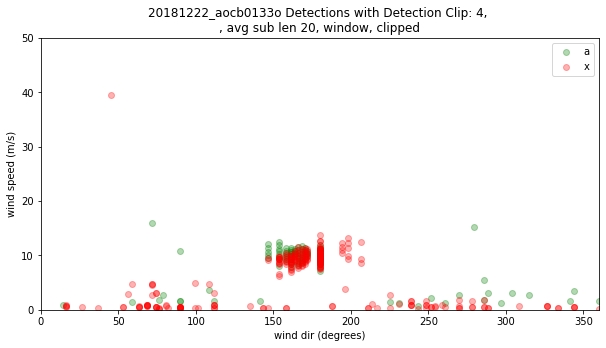

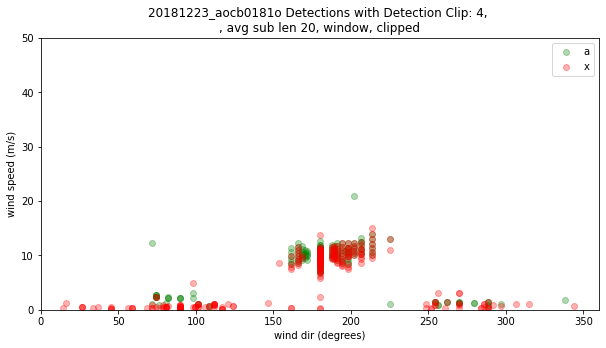

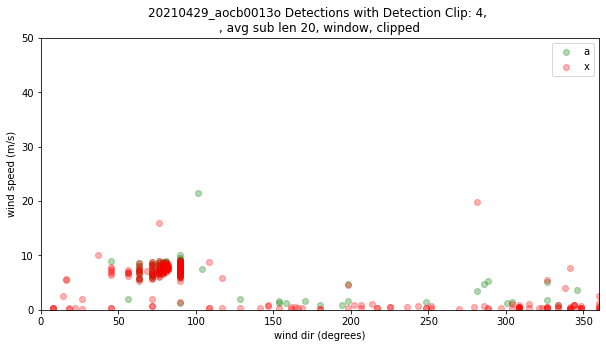

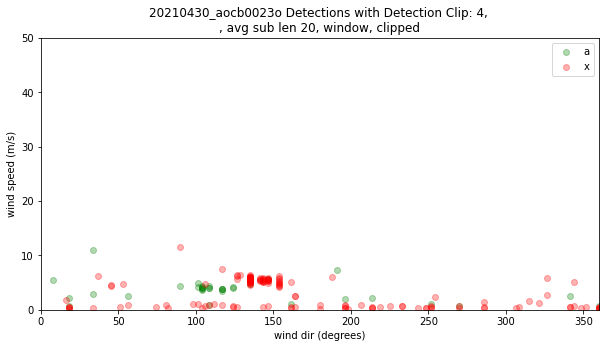

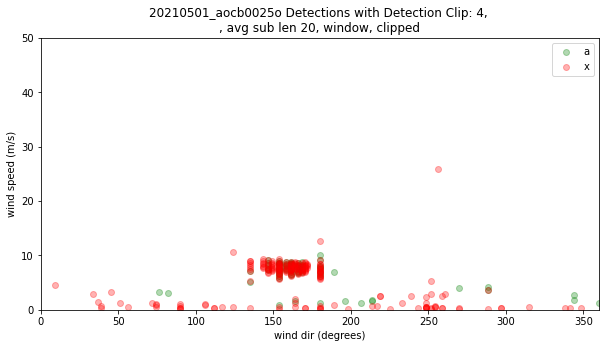

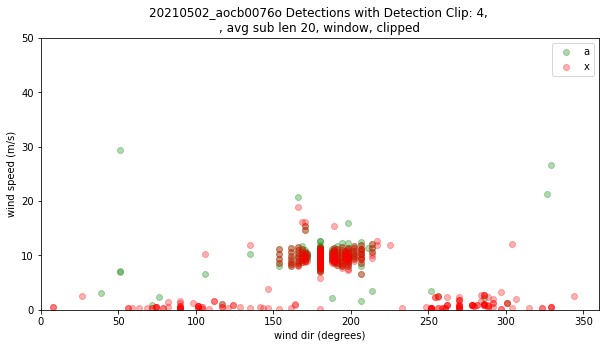

In [341]:
df_test = pd.DataFrame()

for i in range(len(dates)):

    t0 = time.time()
    cor_file = long_files[i]
    print(f"file: {cor_file}")

    er_pipe = er.Estimate_simple(cor_file)
    er_pipe.update_wfs([True, True, True, False, False])
    er_pipe.update_data_params(est_len = 250, bg_sub = True, move_sub = True, sub_len = 20)
    er_pipe.detect_clp = 4

    table_tmp = er_pipe.return_table(sdv_cnd = 2, n_filter = 10)
    n = table_tmp.shape[0]
    #table_tmp = table_tmp.assign(date=[dates[i]]*n, r0=[r0s[j]]*n, vspd=[vspds[k]]*n, vdir=[vdirs[m]]*n)
    table_tmp = table_tmp.assign(est_len=[er_pipe.est_len]*n, bg_sub=[er_pipe.bg_sub]*n, sub_len=[er_pipe.sub_len]*n)

    #add this table to a list of tables                             
    df_test = pd.concat([df_test, table_tmp])
    er_pipe.plot_spds_detect().show()
    t1 = time.time()
    print("== finished in %s s"% str(t1-t0))

In [342]:
df_w20_cl4 = df_test

In [346]:
df_w20_cl4

,dir,dir_std,spd,spd_std,count,class,xcor,name,clstr_method,detect_clp,sdv_comp,sdv_cnd,n_filter,est_len,bg_sub,sub_len
0,332.686418,10.259493,12.398255,1.695949,56.0,FL,0,20180531_aocb0069o,meanshift,4,3,2,10,250,True,20
1,233.446598,25.414765,0.715731,0.386511,40.0,NA,1,20180531_aocb0069o,meanshift,4,3,2,10,250,True,20
2,105.614128,31.448010,0.845154,1.053064,37.0,NA,1,20180531_aocb0069o,meanshift,4,3,2,10,250,True,20
3,317.884798,19.731754,0.583502,0.501016,17.0,NA,1,20180531_aocb0069o,meanshift,4,3,2,10,250,True,20
0,3.659060,7.611287,28.675420,4.368095,32.0,FL,0,20180601_aocb0072o,meanshift,4,3,2,10,250,True,20
1,291.538423,52.239992,2.211239,1.692509,17.0,GL,0,20180601_aocb0072o,meanshift,4,3,2,10,250,True,20
2,290.167099,28.129271,0.719667,0.701374,50.0,GL,1,20180601_aocb0072o,meanshift,4,3,2,10,250,True,20
3,167.038296,28.328470,0.716010,0.835997,25.0,GL,1,20180601_aocb0072o,meanshift,4,3,2,10,250,True,20
4,55.730852,32.221137,1.140320,1.309423,23.0,NA,1,20180601_aocb0072o,meanshift,4,3,2,10,250,True,20
0,33.636970,10.293063,5.601398,0.746672,98.0,GL,0,20181219_aocb0127o,meanshift,4,3,2,10,250,True,20


file: /home/emcewen/out/20180531/fits/20180531_aocb0069o_tmax1000_tts.fits
== finished in 85.48771405220032 s
file: /home/emcewen/out/20180601/fits/20180601_aocb0072o_tmax1000_tts.fits
== finished in 89.65758514404297 s
file: /home/emcewen/out/20181219/fits/20181219_aocb0127o_tmax1000_tts.fits
== finished in 93.04252171516418 s
file: /home/emcewen/out/20181221/fits/20181221_aocb0323o_tmax1000_tts.fits
== finished in 88.02831697463989 s
file: /home/emcewen/out/20181222/fits/20181222_aocb0133o_tmax1000_tts.fits
== finished in 94.03868746757507 s
file: /home/emcewen/out/20181223/fits/20181223_aocb0181o_tmax1000_tts.fits
== finished in 88.29974603652954 s
file: /home/emcewen/out/20210429/fits/20210429_aocb0013o_tmax1000_tts.fits
== finished in 88.75846695899963 s
file: /home/emcewen/out/20210430/fits/20210430_aocb0023o_tmax1000_tts.fits
== finished in 95.78322267532349 s
file: /home/emcewen/out/20210501/fits/20210501_aocb0025o_tmax1000_tts.fits
== finished in 88.41681361198425 s
file: /hom

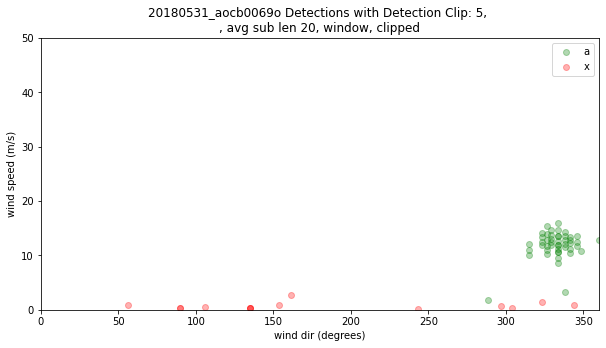

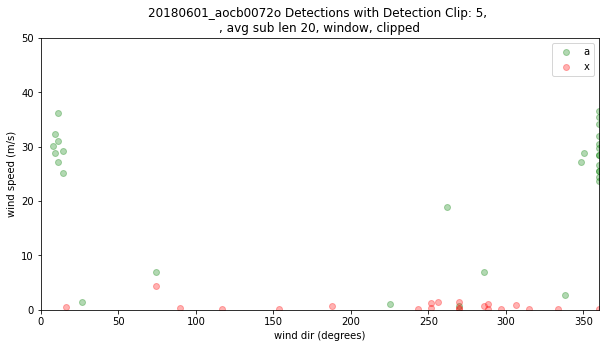

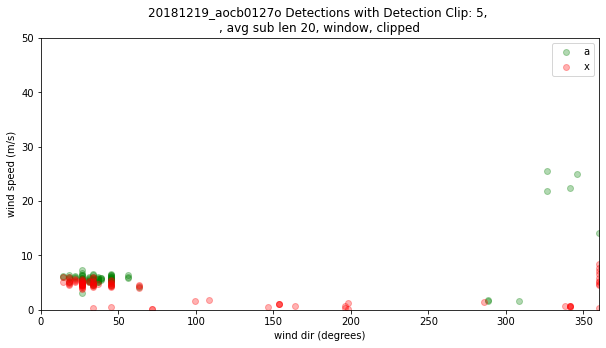

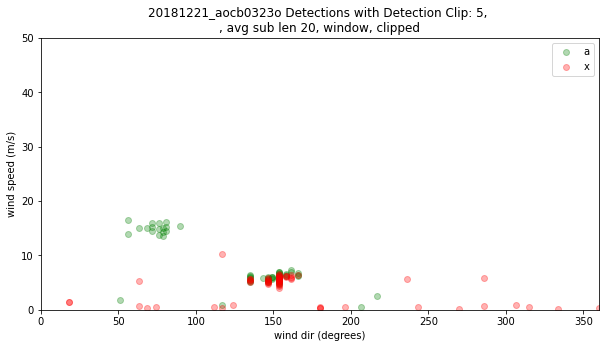

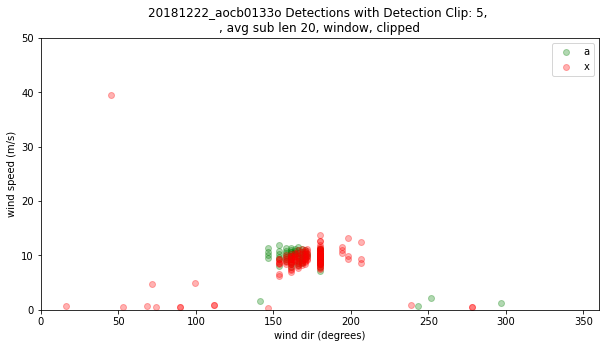

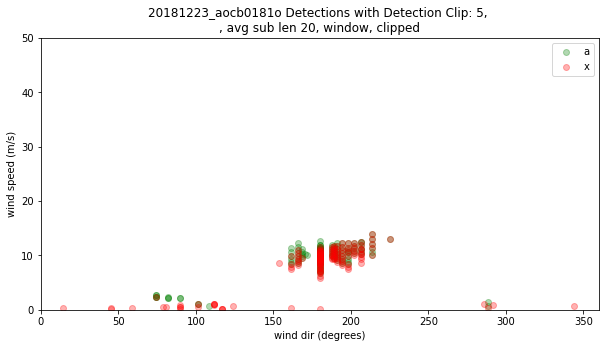

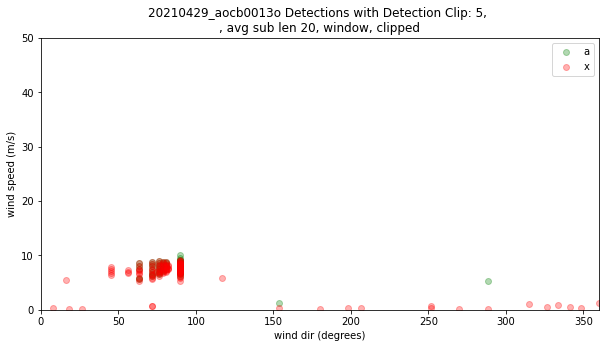

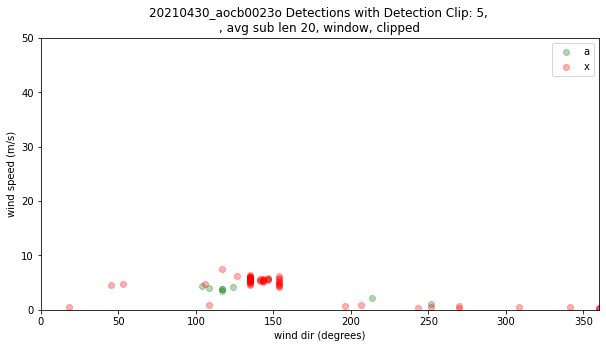

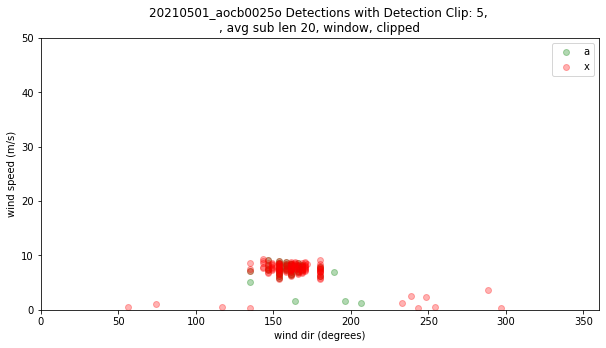

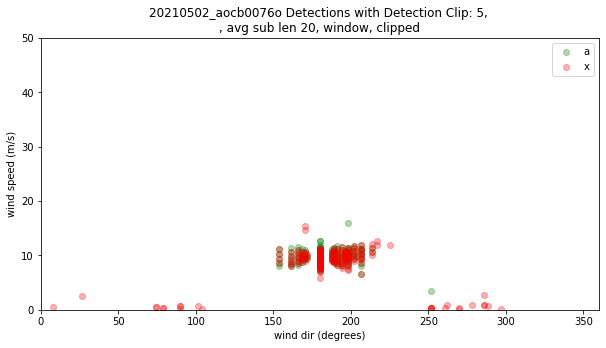

In [343]:
# TEST: short window, higher detection clip

df_test = pd.DataFrame()

for i in range(len(dates)):

    t0 = time.time()
    cor_file = long_files[i]
    print(f"file: {cor_file}")

    er_pipe = er.Estimate_simple(cor_file)
    er_pipe.update_wfs([True, True, True, False, False])
    er_pipe.update_data_params(est_len = 250, bg_sub = True, move_sub = True, sub_len = 20)
    er_pipe.detect_clp = 5

    table_tmp = er_pipe.return_table(sdv_cnd = 2, n_filter = 10)
    n = table_tmp.shape[0]
    #table_tmp = table_tmp.assign(date=[dates[i]]*n, r0=[r0s[j]]*n, vspd=[vspds[k]]*n, vdir=[vdirs[m]]*n)
    table_tmp = table_tmp.assign(est_len=[er_pipe.est_len]*n, bg_sub=[er_pipe.bg_sub]*n, sub_len=[er_pipe.sub_len]*n)

    #add this table to a list of tables                             
    df_test = pd.concat([df_test, table_tmp])
    er_pipe.plot_spds_detect().show()
    t1 = time.time()
    print("== finished in %s s"% str(t1-t0))

In [345]:
df_w20_cl5 = df_test
df_w20_cl5

,dir,dir_std,spd,spd_std,count,class,xcor,name,clstr_method,detect_clp,sdv_comp,sdv_cnd,n_filter,est_len,bg_sub,sub_len
0,333.037270,9.058091,12.371407,1.537975,45.0,FL,0,20180531_aocb0069o,meanshift,5,3,2,10,250,True,20
0,2.968968,6.716834,29.450644,3.631809,23.0,FL,0,20180601_aocb0072o,meanshift,5,3,2,10,250,True,20
1,276.356548,21.602238,0.627116,0.495183,13.0,NA,1,20180601_aocb0072o,meanshift,5,3,2,10,250,True,20
0,34.076650,9.738310,5.640004,0.615492,82.0,GL,0,20181219_aocb0127o,meanshift,5,3,2,10,250,True,20
1,26.272684,13.963050,4.977682,1.139585,65.0,GL,1,20181219_aocb0127o,meanshift,5,3,2,10,250,True,20
0,150.457536,8.454359,5.995061,0.595905,44.0,GL,0,20181221_aocb0323o,meanshift,5,3,2,10,250,True,20
1,73.814870,8.574972,15.010102,0.816748,17.0,FL,0,20181221_aocb0323o,meanshift,5,3,2,10,250,True,20
2,151.260745,7.647684,5.562918,0.606307,41.0,GL,1,20181221_aocb0323o,meanshift,5,3,2,10,250,True,20
0,166.646554,9.568219,9.879397,0.961845,78.0,GL,0,20181222_aocb0133o,meanshift,5,3,2,10,250,True,20
1,172.083255,11.579858,9.582249,1.273942,121.0,GL,1,20181222_aocb0133o,meanshift,5,3,2,10,250,True,20


## AnimationL: Active visualization of detected points

/home/emcewen/.local/lib/python3.6/site-packages/ipykernel_launcher.py:16: RuntimeWarning: invalid value encountered in greater_equal
  app.launch_new_instance()


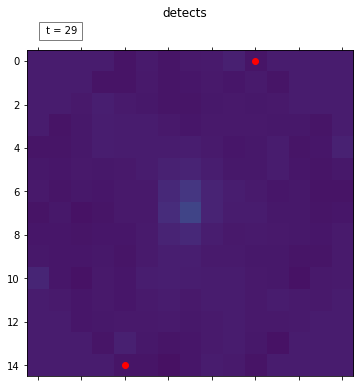

In [317]:
# visualizing what has been detected
mat = er_pipe.acor_map()
dct_lvl = er_pipe.a_d_lvl
detect_val = 3
tmax = 30

gif_1_mat_dlvl(mat, dct_lvl, detect_val, tmax, title = "detects", out_file='out.gif', scale_v = False, label_1 = None)

In [296]:
def gif_1_mat_dlvl(mat, dct_lvl, detect_val, tmax, title = None, out_file='out.gif', scale_v = False, label_1 = None):
    fig, ax = plt.subplots(ncols=1,figsize=(6,6))
    fig.subplots_adjust(wspace=0.3)
    fig.suptitle(str(title))
    ax.set_xticklabels([])
    
    max_val = np.amax(mat)
    min_val = np.amin(mat)

    camera = Camera(fig)
    for t in range(tmax):
        if scale_v:
            im  = ax.matshow(mat[t])
        else:
            im  = ax.matshow(mat[t], vmin=min_val, vmax=max_val)
        idx_t = np.nonzero(dct_lvl[t] >= detect_val)
        ax.scatter(idx_t[0], idx_t[1], c="r")
        ax.text(0.05,1.05," t = " + str(t), bbox=dict(facecolor='white', alpha=0.5), transform=ax.transAxes)
        #fig.colorbar(im, cax=cax)
        camera.snap()
    animation = camera.animate()  
    animation.save(out_file, writer = 'imagemagick')

In [ ]:
# PLOT: background and correlation side by side
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from mpl_toolkits.axes_grid1 import make_axes_locatable

def gif_detect_ani(data1, detect_lvl, title, detect_val, out_file):
    fig, axes = plt.subplots(nrows=1, ncols=1, figsize=(6, 3))
    plt.setp(axes, xticks=[], yticks=[]) # turn off tick marks

    div1 = make_axes_locatable(axes[0])
    cax1 = div1.append_axes('right', '5%', '5%')

    # This is now a list of arrays rather than a list of artists
    d1_0 = data1[0]
    pnt0 = detect_lvl[0]
    idx0 = np.nonzero(pnt0 >= detect_val)

    im1 = axes.imshow(d1_0, origin='lower') # Here make an AxesImage rather than contour
    axes.scatter(idx0)
    cb1 = fig.colorbar(im1, cax=cax1)
    tx = fig.suptitle(f'{title} Step 0')
    
    vstd1 = np.max(data1)
    fig.tight_layout()

    def animate(i):
        vstd1 = np.max(data1[i])
        im1.set_data(data1[i])
        im1.set_clim(-vstd1, +vstd1)

        tx.set_text(f'{title} Step {i}')

    ani = animation.FuncAnimation(fig, animate, frames=30)
    ani.save(out_file, writer = 'imagemagick')